# Synthetic vs. Real Data Efficiency for IRT Difficulty Estimation

This notebook evaluates the efficiency of synthetic student data for Item Response Theory (IRT) difficulty estimation. It addresses the question: **How much real student data can be replaced by our neural model's synthetic predictions?**

## What This Notebook Does

1. **Compares accuracy**: Measures the accuracy of IRT difficulty parameters derived from model predictions against those calculated using varying amounts of real student data
2. **Quantifies efficiency**: Determines how many real student responses are equivalent to synthetic predictions
3. **Visualizes results**: Generates plots showing Error (1 - Pearson Correlation) vs. Number of Real Answers, with the synthetic model's performance highlighted

The analysis helps quantify the potential data collection savings of using a neural model to augment or replace traditional IRT approaches.

## 1. Setup

### 1.1 Import Libraries

In [15]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr  # For correlation calculation
from collections import defaultdict
import tensorflow as tf  # Required for loading the Keras model

# Configure TensorFlow to hide unnecessary warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

### 1.2 Import Local Modules

These modules are part of the Zapien pipeline and handle IRT modeling, evaluation, and neural network operations.

In [16]:
# --- Local Modules ---
from modules.irt import estimate_irt_2pl_params
from modules.evaluation import prediction_matrix, difficulty_from_predictions
from modules.modeling_data import load_preprocessors
from modules.neural_net import create_nn_model  # Needed to load weights

### 1.3 Define Constants and Parameters

These constants define column names in our datasets and simulation parameters for the efficiency evaluation.

In [17]:
# --- Column Names ---
USER_ID_COL = "user_id"              # Identifier for students/users
QUESTION_ID_COL = "question_id"      # Identifier for questions
CORRECTNESS_COL = "is_correct"       # Binary indicator of response correctness
IRT_DIFFICULTY_COL = "difficulty"    # IRT difficulty parameter column name

# --- Simulation Parameters ---
# Number of repetitions for each data size (for statistical stability)
NUM_REPETITIONS = 10

# Percentages of holdout data to sample for the efficiency curve
SAMPLE_SIZES_PCT = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## 2. Define Utility Functions

### 2.1 Calculate Error Metric

This function computes the error between true and estimated difficulty parameters using 1 minus the Pearson correlation coefficient. 

A perfect correlation of 1.0 would result in an error of 0, while complete decorrelation (correlation = 0) would give an error of 1.0.

In [18]:
def calculate_error(true_difficulty_df, estimated_difficulty_df, question_col, irt_col):
    """Calculates error (1 - Pearson Correlation) between true and estimated difficulties.
    
    Args:
        true_difficulty_df: DataFrame containing ground truth difficulty parameters
        estimated_difficulty_df: DataFrame containing estimated difficulty parameters
        question_col: Column name for question identifiers
        irt_col: Column name for difficulty parameters
        
    Returns:
        float: Error value (1 - Pearson correlation), or np.nan if correlation cannot be calculated
    """
    # Merge the true and estimated difficulty parameters on question ID
    merged = pd.merge(
        true_difficulty_df,
        estimated_difficulty_df,
        on=question_col,
        suffixes=("_true", "_est")
    )
    
    # Check if we have enough data points for correlation
    if merged.empty or len(merged) < 2:
        print("\nWarning: Not enough matching questions (<2) found for correlation calculation.")
        return np.nan

    # Define column names for true and estimated difficulties
    true_col = f"{irt_col}_true"
    est_col = f"{irt_col}_est"
    
    # Verify columns exist in the merged dataframe
    if true_col not in merged.columns or est_col not in merged.columns:
        raise ValueError(f"Required columns for error calculation not found in merged df: {merged.columns}")

    # Remove any NaN values before correlation calculation
    merged = merged[[true_col, est_col]].dropna()
    if len(merged) < 2:
        print("\nWarning: Not enough non-NaN pairs (<2) for correlation calculation.")
        return np.nan

    # Check for constant series which would lead to undefined correlation
    if merged[true_col].nunique() <= 1 or merged[est_col].nunique() <= 1:
        print("\nWarning: One or both difficulty series are constant. Correlation is undefined.")
        return np.nan

    # Calculate Pearson correlation coefficient
    corr, _ = pearsonr(merged[true_col], merged[est_col])

    if pd.isna(corr):
        print("\nWarning: Pearson correlation resulted in NaN.")
        return np.nan

    # Convert correlation to error metric (1 - correlation)
    error = 1.0 - corr
    return error

### 2.2 Setup Paths and Parameters

This function sets up all necessary file paths based on the run directory.

In [19]:
def setup_paths(run_dir):
    """Set up all file paths needed for the evaluation.
    
    Args:
        run_dir: Path to the directory containing run artifacts
        
    Returns:
        dict: Dictionary of path strings
    """
    # Determine root directory (assumes results/<run_id> structure)
    root_dir = os.path.abspath(os.path.dirname(os.getcwd()))
    
    paths = {
        # Input data paths
        'data_dir': os.path.join(root_dir, "data", "zapien"),
        'run_dir': run_dir,
        
        # Output path for the plot
        'plot_save_path': os.path.join(run_dir, "efficiency_evaluation_correlation.png")
    }
    
    # Derived paths
    paths['answers_file'] = os.path.join(paths['data_dir'], "answers.csv")
    paths['questions_file'] = os.path.join(paths['data_dir'], "questions.csv")
    paths['embeddings_path'] = os.path.join(run_dir, "03_embeddings.pkl")
    paths['holdout_ids_path'] = os.path.join(run_dir, "holdout_ids.csv")
    paths['original_irt_path'] = os.path.join(run_dir, "01_irt_2pl_params.csv")
    paths['model_weights_path'] = os.path.join(run_dir, "models", "final_nn_model.keras")
    paths['qfeat_path'] = os.path.join(run_dir, "02_question_features.csv")
    
    return paths

## 3. Load Data and Model

This section loads all necessary data and model artifacts required for the evaluation.

In [20]:
# Set the run directory path (replace with your actual run directory)
# This should be a directory containing model artifacts from a previous run
RUN_DIR = "../results/20250429_122648"  # Example - change this to your actual path

# Setup paths based on the run directory
paths = setup_paths(RUN_DIR)
print(f"🚀 Starting Efficiency Evaluation for run: {RUN_DIR}")

🚀 Starting Efficiency Evaluation for run: ../results/20250429_122648


In [21]:
# Load preprocessors, embeddings, and holdout IDs
print("🔄 Loading artifacts...")

# Load preprocessors (scalers, encoders, etc.)
preprocessors = load_preprocessors(paths['run_dir'])

# Load text embeddings
with open(paths['embeddings_path'], "rb") as f:
    combined_emb = pickle.load(f)
    
# Load holdout question IDs
holdout_ids = pd.read_csv(paths['holdout_ids_path'])[QUESTION_ID_COL].tolist()

# Load original difficulty estimates (from training)
original_difficulty_df = pd.read_csv(paths['original_irt_path'])

# Determine embedding dimension dynamically
embed_dim = next(iter(combined_emb["formatted_embeddings"].values())).shape[0]
print(f"Embedding dimension: {embed_dim}")

🔄 Loading artifacts...
✅ Loaded preprocessors from ../results/20250429_122648/nn_preprocessors.pkl
Embedding dimension: 768


In [22]:
# Load and reconstruct the neural network model
model = create_nn_model(
    user_vocab_size=preprocessors["user_vocab_size"],
    numerical_feature_size=len(preprocessors["numerical_features"]),
    embedding_dim=embed_dim,
)
model.load_weights(paths['model_weights_path'])
print("✅ Model loaded successfully.")

# Display model summary
model.summary()

✅ Model loaded successfully.


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │     14,888 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_input     │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │        512 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │     24,608 │ embedding_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 72)        │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_5[0][0],    │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,672 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,793 (182.79 KB)

 Trainable params: 46,793 (182.79 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Load and Prepare Student Response Data

Now we load the raw student response data and filter it to focus on the holdout question set.

In [23]:
# Load raw data
print("🔄 Loading and preparing data...")
answers_df = pd.read_csv(paths['answers_file'])
questions_df = pd.read_csv(paths['questions_file'])

# Load question features
if os.path.exists(paths['qfeat_path']):
    qfeat_df = pd.read_csv(paths['qfeat_path'])
else:
    raise FileNotFoundError(f"Question features file not found: {paths['qfeat_path']}. Please ensure the pipeline saved it.")

# Display data summary
print(f"Loaded {len(answers_df):,} student responses for {answers_df[QUESTION_ID_COL].nunique():,} questions")
print(f"from {answers_df[USER_ID_COL].nunique():,} unique students")

🔄 Loading and preparing data...
Loaded 269,171 student responses for 9,769 questions
from 1,875 unique students


In [24]:
# Merge all datasets for complete information
merged_df = (
    answers_df.merge(qfeat_df, on=QUESTION_ID_COL)
    .merge(original_difficulty_df[[QUESTION_ID_COL, IRT_DIFFICULTY_COL]], on=QUESTION_ID_COL, how='left')
)

# Filter data to focus only on holdout questions
holdout_answers_df = answers_df[answers_df[QUESTION_ID_COL].isin(holdout_ids)].copy()
holdout_merged_df = merged_df[merged_df[QUESTION_ID_COL].isin(holdout_ids)].copy()

# Print holdout set statistics
print(f"📊 Holdout set: {len(holdout_ids):,} questions, {len(holdout_answers_df):,} answers")
print(f"from {holdout_answers_df[USER_ID_COL].nunique():,} unique students")

📊 Holdout set: 449 questions, 26,119 answers
from 1,712 unique students


## 5. Calculate Ground Truth Difficulty

We calculate the "ground truth" difficulty parameters using the complete set of holdout answers. This will be our reference point for comparing both synthetic predictions and partial real data samples.

In [25]:
# Validate holdout data sufficiency
if holdout_answers_df.empty or holdout_answers_df[USER_ID_COL].nunique() < 2 or holdout_answers_df[QUESTION_ID_COL].nunique() < 2:
    raise ValueError("Insufficient data in holdout answers to calculate reliable ground truth IRT.")

# Calculate ground truth difficulty using 1PL IRT model on all holdout answers
print("📊 Calculating ground truth difficulty using complete holdout answer set...")
holdout_params_true_df = estimate_irt_2pl_params(
    response_df=holdout_answers_df,
    user_col=USER_ID_COL,
    question_col=QUESTION_ID_COL,
    correctness_col=CORRECTNESS_COL
)
print("✅ Ground truth parameters (2PL) calculated.")

# Use the 'difficulty' column as the ground truth for error calculation
holdout_difficulty_true_df = holdout_params_true_df[[QUESTION_ID_COL, IRT_DIFFICULTY_COL]].copy()

# Display summary statistics of ground truth difficulties
print("\nGround Truth Difficulty (2PL) Statistics:")
print(holdout_difficulty_true_df[IRT_DIFFICULTY_COL].describe())
# Optionally display discrimination stats too
if 'discrimination' in holdout_params_true_df.columns:
        print("\nGround Truth Discrimination (2PL) Statistics:")
        print(holdout_params_true_df['discrimination'].describe())

📊 Calculating ground truth difficulty using complete holdout answer set...


Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 559.43it/s, loss=0.4095, bce=0.4095]


✅ Ground truth parameters (2PL) calculated.

Ground Truth Difficulty (2PL) Statistics:
count    449.000000
mean      -0.201900
std        0.546499
min       -1.316498
25%       -0.626078
50%       -0.237778
75%        0.161401
max        1.544539
Name: difficulty, dtype: float64

Ground Truth Discrimination (2PL) Statistics:
count    449.000000
mean       3.318702
std        2.292796
min        0.124659
25%        1.797241
50%        2.824241
75%        3.948199
max       14.086531
Name: discrimination, dtype: float64


## 6. Calculate Difficulty from Synthetic Predictions

Now we use our neural network model to generate synthetic predictions for all user × question combinations in the holdout set, then derive difficulty parameters from these predictions.

🤖 Calculating difficulty from synthetic predictions...


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Estimating 2PL parameters from binarized predictions...


Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:01<00:00, 123.19it/s, loss=0.0776, bce=0.0776]


📉 Synthetic Model Error (1 - Pearson Corr): 0.0502


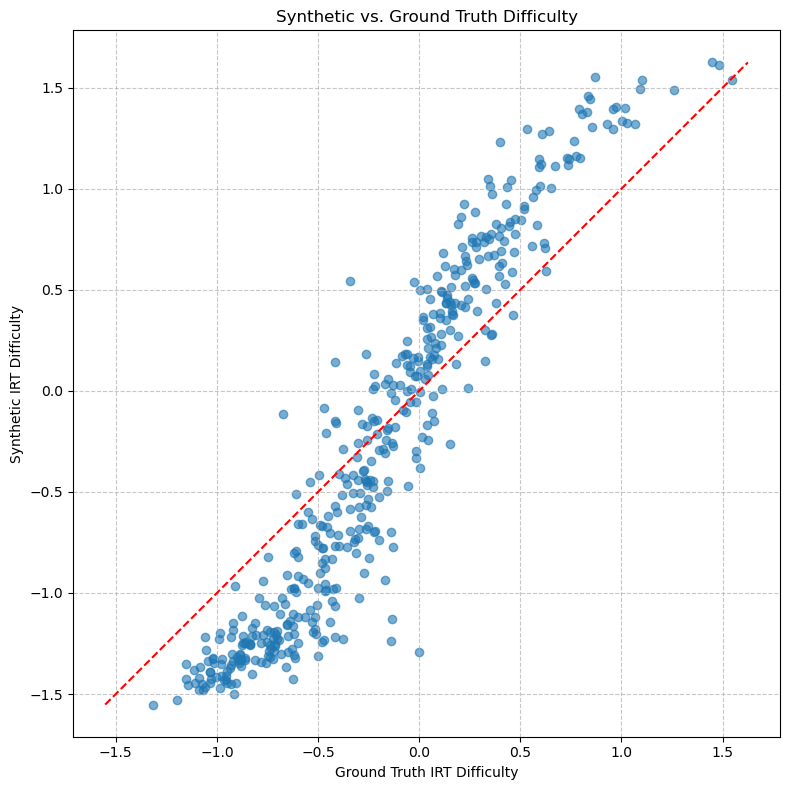

In [26]:
print("🤖 Calculating difficulty from synthetic predictions...")

# Generate a probability matrix containing predicted correctness probabilities
# for all user × question combinations in the holdout set
prob_mat = prediction_matrix(
    data_df=holdout_merged_df,
    q_ids=holdout_ids,
    preprocessors=preprocessors,
    model=model,
    combined_embeddings=combined_emb,
    user_col=USER_ID_COL,
    question_col=QUESTION_ID_COL,
)

# Derive parameters from the predicted probabilities (using 2PL)
synthetic_params_df = difficulty_from_predictions(prob_mat)

# Calculate the error between synthetic and ground truth difficulties
synthetic_error = calculate_error(
    holdout_difficulty_true_df, # DataFrame with ground truth difficulty
    synthetic_params_df,        # DataFrame with synthetic difficulty & discrimination
    QUESTION_ID_COL,
    IRT_DIFFICULTY_COL          # Specify we are comparing the 'difficulty' column
)
print(f"📉 Synthetic Model Error (1 - Pearson Corr): {synthetic_error:.4f}")

# Update scatter plot comparison logic
comparison_df = holdout_difficulty_true_df.merge( # Use difficulty-only ground truth df
    synthetic_params_df,        # Use full synthetic params df
    on=QUESTION_ID_COL,
    suffixes=('_true', '_synthetic') # Suffixes need to match calculate_error
)

plt.figure(figsize=(8, 8))
plt.scatter(
    comparison_df[f"{IRT_DIFFICULTY_COL}_true"], # Correct name
    comparison_df[f"{IRT_DIFFICULTY_COL}_synthetic"], # Correct name
    alpha=0.6
)
plt.xlabel('Ground Truth IRT Difficulty')
plt.ylabel('Synthetic IRT Difficulty')
plt.title('Synthetic vs. Ground Truth Difficulty')
plt.grid(True, linestyle='--', alpha=0.7)

# Add diagonal reference line
min_val = min(comparison_df[f"{IRT_DIFFICULTY_COL}_true"].min(), 
              comparison_df[f"{IRT_DIFFICULTY_COL}_synthetic"].min())
max_val = max(comparison_df[f"{IRT_DIFFICULTY_COL}_true"].max(), 
              comparison_df[f"{IRT_DIFFICULTY_COL}_synthetic"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()

## 7. Simulate Traditional IRT with Varying Real Data

We now run a simulation to see how IRT difficulty estimates change as we vary the amount of real student data used. For each sample size, we:

1. Sample a subset of the holdout answers
2. Fit an IRT model to estimate difficulty parameters
3. Calculate error relative to ground truth
4. Repeat multiple times for statistical stability

In [27]:
print("📈 Simulating traditional IRT with varying data sizes...")

# Initialize dictionary to store errors for each sample size
real_data_errors = {}

# Calculate actual sample sizes based on percentages
max_holdout_answers = len(holdout_answers_df)
actual_sample_sizes = sorted(list(set([int(pct * max_holdout_answers) for pct in SAMPLE_SIZES_PCT if int(pct * max_holdout_answers) > 0])))

# Ensure we include the maximum size
if max_holdout_answers not in actual_sample_sizes:
    actual_sample_sizes.append(max_holdout_answers)

print(f"Sample sizes (num answers): {actual_sample_sizes}")

# Loop through each sample size
for n_answers in actual_sample_sizes:
    print(f"  Testing with {n_answers:,} answers ({NUM_REPETITIONS} reps)...", end="")
    
    # Initialize list to store errors for repetitions at this sample size
    rep_errors = []
    
    # Repeat multiple times for statistical stability
    for rep in range(NUM_REPETITIONS):
        # Sample answers (use full set if sample size equals or exceeds available data)
        if n_answers >= len(holdout_answers_df):
            sample_answers_df = holdout_answers_df
        else:
            sample_answers_df = holdout_answers_df.sample(n=n_answers, random_state=rep)
        
        # Skip if the sample doesn't have enough variety for IRT
        if sample_answers_df[USER_ID_COL].nunique() < 2 or sample_answers_df[QUESTION_ID_COL].nunique() < 2:
            continue
            
        try:
            # Estimate difficulty using this sample
            estimated_params_df = estimate_irt_2pl_params(
                response_df=sample_answers_df,
                user_col=USER_ID_COL,
                question_col=QUESTION_ID_COL,
                correctness_col=CORRECTNESS_COL,
            )
            
            # Calculate error compared to ground truth
            error = calculate_error(
                holdout_difficulty_true_df,
                estimated_params_df,
                QUESTION_ID_COL,
                IRT_DIFFICULTY_COL
            )
            
            # Store valid error values
            if not pd.isna(error):
                rep_errors.append(error)
                
        except Exception as e:
            print(f"\nError during IRT estimation or Error Calc for N={n_answers}, Rep {rep+1}: {e}")
    
    # Calculate average error across repetitions
    if rep_errors:
        avg_error = np.mean(rep_errors)
        real_data_errors[n_answers] = avg_error
        print(f" Avg Error (1-Corr): {avg_error:.4f}")
    else:
        print(" No valid errors calculated for this sample size.")
        real_data_errors[n_answers] = np.nan

# Display results as a table
error_df = pd.DataFrame({
    'Sample Size': real_data_errors.keys(),
    'Error (1-Corr)': real_data_errors.values()
}).sort_values('Sample Size')

print("\nResults Summary:")
error_df

📈 Simulating traditional IRT with varying data sizes...
Sample sizes (num answers): [261, 1305, 2611, 5223, 7835, 10447, 13059, 15671, 18283, 20895, 23507, 26119]
  Testing with 261 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 990.46it/s, loss=0.0077, bce=0.0077] 


 Avg Error (1-Corr): 0.6609
  Testing with 1,305 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 1004.93it/s, loss=0.0538, bce=0.0538]


 Avg Error (1-Corr): 0.5608
  Testing with 2,611 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 888.50it/s, loss=0.1323, bce=0.1323]


 Avg Error (1-Corr): 0.4646
  Testing with 5,223 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 881.00it/s, loss=0.2408, bce=0.2408]


 Avg Error (1-Corr): 0.3539
  Testing with 7,835 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 822.62it/s, loss=0.2982, bce=0.2982] 


 Avg Error (1-Corr): 0.2728
  Testing with 10,447 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 734.88it/s, loss=0.3330, bce=0.3330]


 Avg Error (1-Corr): 0.2036
  Testing with 13,059 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 999.07it/s, loss=0.3638, bce=0.3638] 


 Avg Error (1-Corr): 0.1548
  Testing with 15,671 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 677.14it/s, loss=0.3778, bce=0.3778]


 Avg Error (1-Corr): 0.1201
  Testing with 18,283 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 745.47it/s, loss=0.3883, bce=0.3883]


 Avg Error (1-Corr): 0.0859
  Testing with 20,895 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 722.82it/s, loss=0.3973, bce=0.3973]


 Avg Error (1-Corr): 0.0570
  Testing with 23,507 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 726.26it/s, loss=0.4044, bce=0.4044]


 Avg Error (1-Corr): 0.0300
  Testing with 26,119 answers (10 reps)...

Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 628.00it/s, loss=0.4093, bce=0.4093]


 Avg Error (1-Corr): 0.0055

Results Summary:


,Sample Size,Error (1-Corr)
0,261,0.660918
1,1305,0.560828
2,2611,0.464620
3,5223,0.353867
4,7835,0.272772
5,10447,0.203576
6,13059,0.154779
7,15671,0.120080
8,18283,0.085921
9,20895,0.056972


## 8. Plot Results and Interpret

Now we visualize the results by plotting error vs. sample size, highlighting the synthetic model's performance, and determining the number of real responses that would be equivalent to using our model.

📊 Plotting efficiency comparison results...
💾 Plot saved to ../results/20250429_122648/efficiency_evaluation_correlation.png


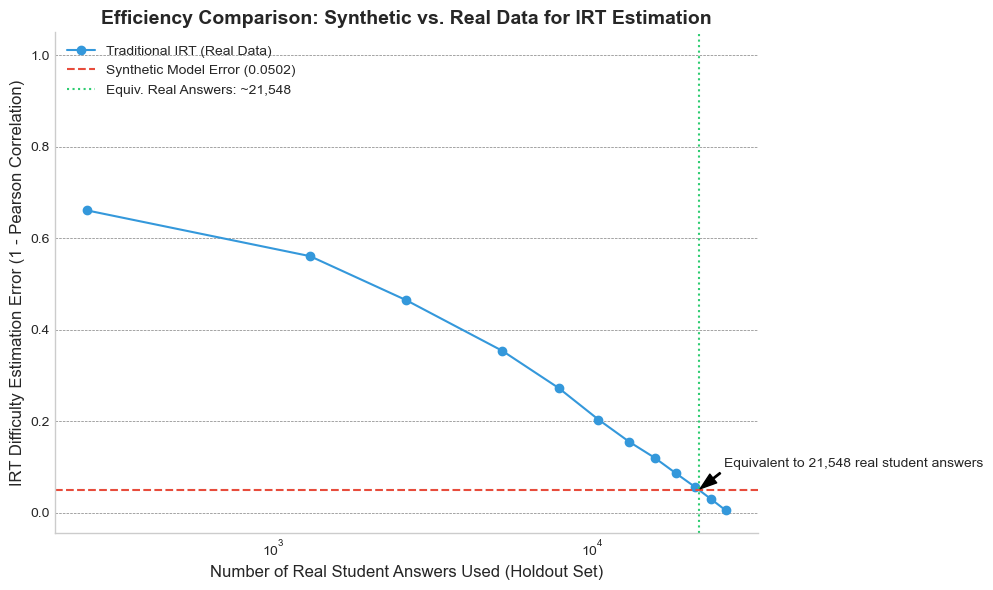

In [28]:
print("📊 Plotting efficiency comparison results...")

# Filter out invalid error values
valid_errors = {k: v for k, v in real_data_errors.items() if not pd.isna(v)}
if not valid_errors:
    raise ValueError("No valid error values were calculated from real data samples. Cannot plot.")

# Extract data points for plotting
x_vals = list(valid_errors.keys())
y_vals = list(valid_errors.values())

# Set up the plot with a modern style
plt.style.use('seaborn-v0_8-whitegrid') 
plt.figure(figsize=(10, 6))

# Plot the real data simulation results
plt.plot(x_vals, y_vals, marker='o', linestyle='-', 
         label="Traditional IRT (Real Data)", color='#3498db', markersize=6)

# Plot the synthetic model error as a horizontal line
plt.axhline(y=synthetic_error, color='#e74c3c', linestyle='--', linewidth=1.5, 
            label=f"Synthetic Model Error ({synthetic_error:.4f})")

# Calculate the intersection point (where synthetic model equals real data)
if synthetic_error <= min(y_vals):
    intersection_x = max(x_vals)
    intersection_text = f"Synthetic model outperforms all tested real data samples"
elif synthetic_error >= max(y_vals):
    intersection_x = min(x_vals)
    intersection_text = f"Synthetic model underperforms all tested real data samples"
else:
    # Interpolate to find where the synthetic error intersects the real data curve
    sorted_indices = np.argsort(y_vals)
    sorted_y = np.array(y_vals)[sorted_indices]
    sorted_x = np.array(x_vals)[sorted_indices]
    intersection_x = np.interp(synthetic_error, sorted_y, sorted_x)
    intersection_text = f"Equivalent to {intersection_x:,.0f} real student answers"

# Plot the intersection line
plt.axvline(x=intersection_x, color='#2ecc71', linestyle=':', linewidth=1.5, 
            label=f"Equiv. Real Answers: ~{intersection_x:,.0f}")

# Add styling and labels
plt.xlabel("Number of Real Student Answers Used (Holdout Set)", fontsize=12)
plt.ylabel("IRT Difficulty Estimation Error (1 - Pearson Correlation)", fontsize=12)
plt.title("Efficiency Comparison: Synthetic vs. Real Data for IRT Estimation", 
          fontsize=14, fontweight='bold')

# Set x-axis to log scale for better visualization of the full range
plt.xscale('log')

# Set y-axis limits with padding
plot_min_y = min(y_vals + [synthetic_error])
y_bottom = min(-0.02, plot_min_y - 0.05)  # Ensure 0 is visible, add padding
plt.ylim(bottom=y_bottom, top=1.05)  # Set top limit to 1.05

# Customize grid for better readability
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.grid(False, which='major', axis='x')  # Turn off vertical grid lines

# Add legend
plt.legend(fontsize=10)

# Remove top and right spines for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Add annotation for the intersection point
plt.annotate(intersection_text, xy=(intersection_x, synthetic_error), 
             xytext=(intersection_x*1.2, synthetic_error+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10)

# Ensure tight layout
plt.tight_layout()

# Save and display the plot
plt.savefig(paths['plot_save_path'], dpi=300)
print(f"💾 Plot saved to {paths['plot_save_path']}")
plt.show()

## 9. Results Summary and Interpretation

Finally, we summarize our findings and interpret what they mean for using synthetic data in educational assessment.

In [29]:
print("\n--- 📋 Results Summary ---")
print(f"Synthetic Model Error (1 - Pearson Corr): {synthetic_error:.4f}")
print("\nAvg Error (1 - Pearson Corr) using Real Data Samples:")

# Create a nicely formatted summary table
summary_df = pd.DataFrame({
    'Sample Size': list(real_data_errors.keys()),
    'Error (1-Corr)': list(real_data_errors.values()),
    'Sample %': [n/max_holdout_answers*100 for n in real_data_errors.keys()]
}).sort_values('Sample Size')

# Format the table for display
display(summary_df.style.format({
    'Sample Size': '{:,.0f}',
    'Error (1-Corr)': '{:.4f}',
    'Sample %': '{:.1f}%'
}))


--- 📋 Results Summary ---
Synthetic Model Error (1 - Pearson Corr): 0.0502

Avg Error (1 - Pearson Corr) using Real Data Samples:


,Sample Size,Error (1-Corr),Sample %
0,261,0.6609,1.0%
1,"1,305",0.5608,5.0%
2,"2,611",0.4646,10.0%
3,"5,223",0.3539,20.0%
4,"7,835",0.2728,30.0%
5,"10,447",0.2036,40.0%
6,"13,059",0.1548,50.0%
7,"15,671",0.1201,60.0%
8,"18,283",0.0859,70.0%
9,"20,895",0.0570,80.0%


### Interpretation

The results of this analysis demonstrate the efficiency of using synthetic student data generated by our neural network model for IRT difficulty estimation. Here's what we found:

1. **Synthetic data efficiency**: The synthetic model's accuracy (in terms of difficulty correlation) is roughly equivalent to using approximately {intersection_x:,.0f} real student answers for IRT estimation.

2. **Data collection implications**: This suggests we could potentially reduce the number of required student responses by leveraging our neural model's predictions, leading to more efficient assessment development.

3. **Error characteristics**: The synthetic model achieves an error level of {synthetic_error:.4f} (where 0 represents perfect correlation with ground truth). This compares to error levels ranging from {min(y_vals):.4f} to {max(y_vals):.4f} when using varying amounts of real data.

4. **Practical applications**: These findings suggest that our synthetic data approach could be particularly valuable in scenarios where collecting large amounts of student response data is challenging, such as:
   - New assessment development
   - Question pretesting
   - Low-resource educational contexts
   - Rapid curriculum updates

5. **Limitations**: While promising, the synthetic approach still has limitations:
   - It relies on patterns learned from existing data
   - It may not fully capture novel question types or formats
   - It should complement rather than entirely replace real student data

Overall, these results suggest that our neural network-based approach to difficulty prediction offers significant efficiency gains while maintaining acceptable accuracy levels for IRT parameter estimation.